# PW05 - Group 4
* Florian Bär
* Matthias Egli
* Manuel Vogel
* Adrian Willi

In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

### Utilities

The test function that is used for illustrating the workings of the optimisers.

In [2]:
def test_function(x):
    return x[0]**2/15.0+x[1]**2

Utility for plotting the contours of a given function`f` in a range `r` (4-tuple) and 20 levels up to a max level given by `s`. 

In [3]:
def plot_contours(r, s, f):
    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'
    delta = 0.01
    X = np.arange(r[0], r[1], delta)
    Y = np.arange(r[2], r[3], delta)
    X,Y = np.meshgrid(X, Y)  
    XX = np.stack((X,Y), axis=0)
    Z=f(XX)
    V=np.arange(0.2,s,s/20)**2
    #CS = plt.contour(X, Y, Z, V, colors=colors)
    #plt.clabel(CS, inline=1, fontsize=10)
    CS = plt.contour(X, Y, Z, V)

Optimisation (i.e. minimisation) of the function `f` starting at `x` (pytorch tensor), by using the given `optimizer` over`nepochs`epochs.  

In [4]:
def optimize(f, x, nepochs, optimizer):
    params = [
        x,
    ]
    xhist = [x[0].item()]
    yhist = [x[1].item()]
    optimizer.param_groups[0]["params"] = params

    epochs_to_optima = 0
    for i in range(nepochs):
        y = f(x)
        optimizer.zero_grad()
        y.backward()
        optimizer.step()
        if (
            np.sqrt(x[0].item() ** 2 + x[1].item() ** 2) <= 0.001
            and epochs_to_optima != 1
        ):
            print(f"Took {str(i + 1)} steps to the optima: ", end="")
            epochs_to_optima += 1

        xhist.append(x[0].item())
        yhist.append(x[1].item())
    return xhist, yhist


RMS error for measuring the discrepancy to the final target (for the test function above it is (0,0). 

In [5]:
def error(xhist,yhist):
    x,y = xhist[-1], yhist[-1]
    return "%6.3f, (%6.3f, %6.3f)"%(np.sqrt(x**2+y**2),x,y)

### Sample Run

Took 197 steps to the optima: SGD - lr=0.3   0.001, (-0.001,  0.000)


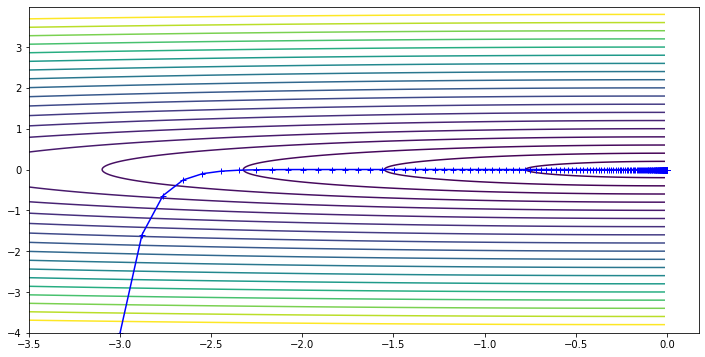

In [6]:
nepochs = 200

plt.figure(1,figsize=(12,6))
plot_contours([-3.5,0.,-4.,4.], 4., test_function)

# initial value
x = torch.tensor([-3.0,-4.0]).requires_grad_()

optimizer = torch.optim.SGD([x],lr=.3)
xhist, yhist = optimize(test_function, x, nepochs, optimizer)  

plt.plot(xhist,yhist,"b-+", label="lr=0.3")
print("SGD - lr=0.3 ", error(xhist,yhist))


### Tasks 

For better comparison, always use the same (non-optimal) initial point.  

* Study SGD for different learning rates.
* Compare Momentum for different momentum parameters and characterise how the optimisation paths qualitatively change.
* Can you spot a difference with / without Nesterov? 
* Play with different settings for the parameter $\beta_1$ and characterise how the optimisation paths qualitatively change.
* Finally, check different settings for Adam. Experiment with different learning rates. Can you experimentally verify that Adam is less sensitive to the choice of the learning rate than e.g. SGD?
* Identify your best parameters for each of the models above - for the given example. How many steps are needed with these settings to reach the minimum of the function at (0,0) within an accuracy of 1.0e-3


In [7]:
nepochs = 20

# initial value
x = torch.tensor([-3.0,-4.0]).requires_grad_()

In [8]:
from itertools import product
from typing import List


def print_learning(
    optimizer_name: str,
    lrs: List[float] = [0.001],
    momentums: List[float] = [0],
    nesterov: bool = False,
    b1s: List[float] = [0.9],
):
    plt.figure(1, figsize=(12, 6))
    plot_contours([-3.5, 0.0, -4.0, 4.0], 4.0, test_function)

    for lr, momentum in product(lrs, momentums):
        for b1 in b1s:
            nepochs = 200

            plt.figure(1, figsize=(12, 6))
            plot_contours([-3.5, 0.0, -4.0, 4.0], 4.0, test_function)

            # initial value
            x = torch.tensor([-3.0, -4.0]).requires_grad_()

            if optimizer_name == "SGD":
                optimizer = torch.optim.SGD(
                    [x], lr=lr, momentum=momentum, nesterov=nesterov
                )
            elif optimizer_name == "Adam":
                optimizer = torch.optim.Adam([x], lr=lr, betas=(b1, 0.999))
            else:
                raise NotImplementedError()

            xhist, yhist = optimize(test_function, x, nepochs, optimizer)

            plt.plot(
                xhist,
                yhist,
                "-+",
                label=f"lr={lr}, momentum={momentum}, nesterov={nesterov}, b1={b1}",
                color=(np.random.random(), np.random.random(), np.random.random()),
            )
            plt.legend(loc="best")
            print(f"{optimizer_name} - lr={lr} - momentum={momentum}, nesterov={nesterov}, b1={b1}", error(xhist, yhist))


#### 1. SDG for different learning rates

SGD - lr=0.001 - momentum=0, nesterov=False, b1=0.9  3.964, (-2.921, -2.680)
SGD - lr=0.01 - momentum=0, nesterov=False, b1=0.9  2.298, (-2.297, -0.070)
SGD - lr=0.1 - momentum=0, nesterov=False, b1=0.9  0.205, (-0.205, -0.000)
Took 117 steps to the optima: SGD - lr=0.5 - momentum=0, nesterov=False, b1=0.9  0.000, (-0.000,  0.000)
SGD - lr=1.0 - momentum=0, nesterov=False, b1=0.9  4.000, (-0.000, -4.000)


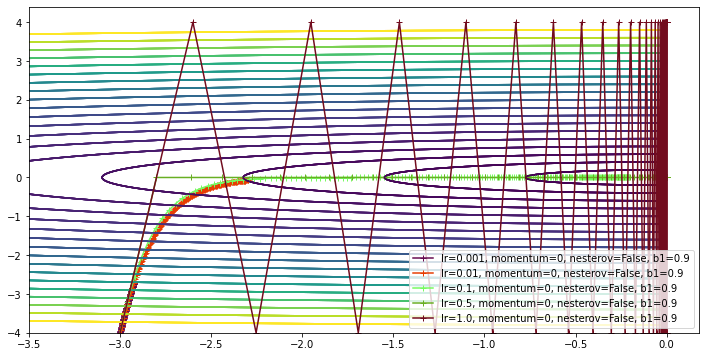

In [9]:
print_learning(optimizer_name="SGD", lrs=[0.001, 0.01, 0.1, 0.5, 1.0])

#### 2. Compare Momentum for different momentum parameters and characterise how the optimisation paths qualitatively change.

SGD - lr=0.001 - momentum=0.1, nesterov=False, b1=0.9  3.880, (-2.912, -2.564)
SGD - lr=0.001 - momentum=0.30000000000000004, nesterov=False, b1=0.9  3.666, (-2.888, -2.258)
SGD - lr=0.001 - momentum=0.5, nesterov=False, b1=0.9  3.364, (-2.845, -1.796)
SGD - lr=0.001 - momentum=0.7000000000000001, nesterov=False, b1=0.9  2.939, (-2.747, -1.044)
SGD - lr=0.001 - momentum=0.9, nesterov=False, b1=0.9  2.319, (-2.318, -0.028)
SGD - lr=0.01 - momentum=0.1, nesterov=False, b1=0.9  2.231, (-2.230, -0.044)
SGD - lr=0.01 - momentum=0.30000000000000004, nesterov=False, b1=0.9  2.050, (-2.050, -0.011)
SGD - lr=0.01 - momentum=0.5, nesterov=False, b1=0.9  1.761, (-1.761, -0.001)
SGD - lr=0.01 - momentum=0.7000000000000001, nesterov=False, b1=0.9  1.232, (-1.232, -0.000)
SGD - lr=0.01 - momentum=0.9, nesterov=False, b1=0.9  0.157, (-0.157,  0.000)
SGD - lr=0.1 - momentum=0.1, nesterov=False, b1=0.9  0.151, (-0.151, -0.000)
SGD - lr=0.1 - momentum=0.30000000000000004, nesterov=False, b1=0.9  0.063, 

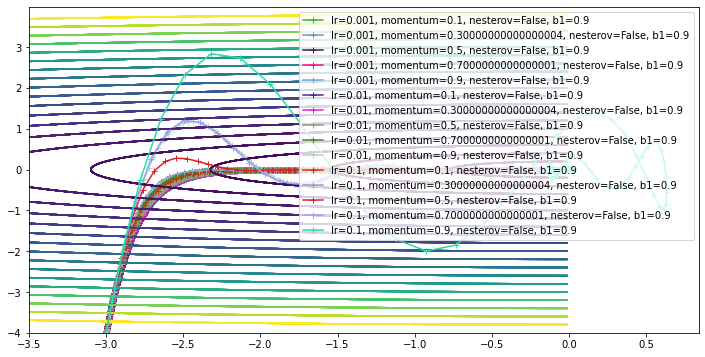

In [10]:
print_learning(optimizer_name="SGD", lrs=[0.001, 0.01, 0.1], momentums=np.linspace(0.1, 0.9, 5))

#### 3. Can you spot a difference with / without Nesterov? 

SGD - lr=0.001 - momentum=0.1, nesterov=True, b1=0.9  3.880, (-2.912, -2.563)
SGD - lr=0.001 - momentum=0.30000000000000004, nesterov=True, b1=0.9  3.665, (-2.888, -2.257)
SGD - lr=0.001 - momentum=0.5, nesterov=True, b1=0.9  3.364, (-2.845, -1.795)
SGD - lr=0.001 - momentum=0.7000000000000001, nesterov=True, b1=0.9  2.939, (-2.747, -1.046)
SGD - lr=0.001 - momentum=0.9, nesterov=True, b1=0.9  2.317, (-2.316, -0.032)
SGD - lr=0.01 - momentum=0.1, nesterov=True, b1=0.9  2.231, (-2.230, -0.045)
SGD - lr=0.01 - momentum=0.30000000000000004, nesterov=True, b1=0.9  2.049, (-2.049, -0.012)
SGD - lr=0.01 - momentum=0.5, nesterov=True, b1=0.9  1.760, (-1.760, -0.001)
SGD - lr=0.01 - momentum=0.7000000000000001, nesterov=True, b1=0.9  1.232, (-1.232, -0.000)
SGD - lr=0.01 - momentum=0.9, nesterov=True, b1=0.9  0.162, (-0.162, -0.000)
SGD - lr=0.1 - momentum=0.1, nesterov=True, b1=0.9  0.152, (-0.152, -0.000)
SGD - lr=0.1 - momentum=0.30000000000000004, nesterov=True, b1=0.9  0.064, (-0.064, -0.

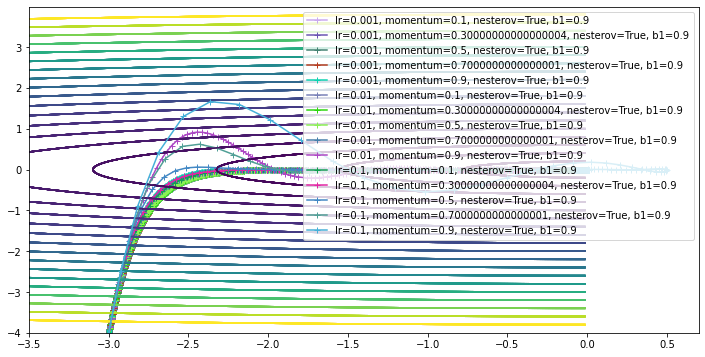

In [11]:
print_learning(optimizer_name="SGD", lrs=[0.001, 0.01, 0.1], momentums=np.linspace(0.1, 0.9, 5), nesterov=True)

#### 4. Play with different settings for the parameter $\beta_1$ and characterise how the optimisation paths qualitatively change.
#### 5. Finally, check different settings for Adam. Experiment with different learning rates. Can you experimentally verify that Adam is less sensitive to the choice of the learning rate than e.g. SGD?

Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.01  2.638, (-1.357, -2.263)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.10888888888888888  2.637, (-1.356, -2.262)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.20777777777777778  2.637, (-1.355, -2.262)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.30666666666666664  2.635, (-1.354, -2.261)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.40555555555555556  2.634, (-1.353, -2.260)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.5044444444444445  2.632, (-1.352, -2.258)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.6033333333333333  2.629, (-1.349, -2.256)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.7022222222222222  2.624, (-1.345, -2.253)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.8011111111111111  2.614, (-1.337, -2.246)
Adam - lr=0.01 - momentum=0, nesterov=False, b1=0.9  2.586, (-1.313, -2.227)
Took 59 steps to the optima: Adam - lr=0.2575 - momentum=0, nesterov=False, b1=0.01  0.000, (-0.000, -0.0

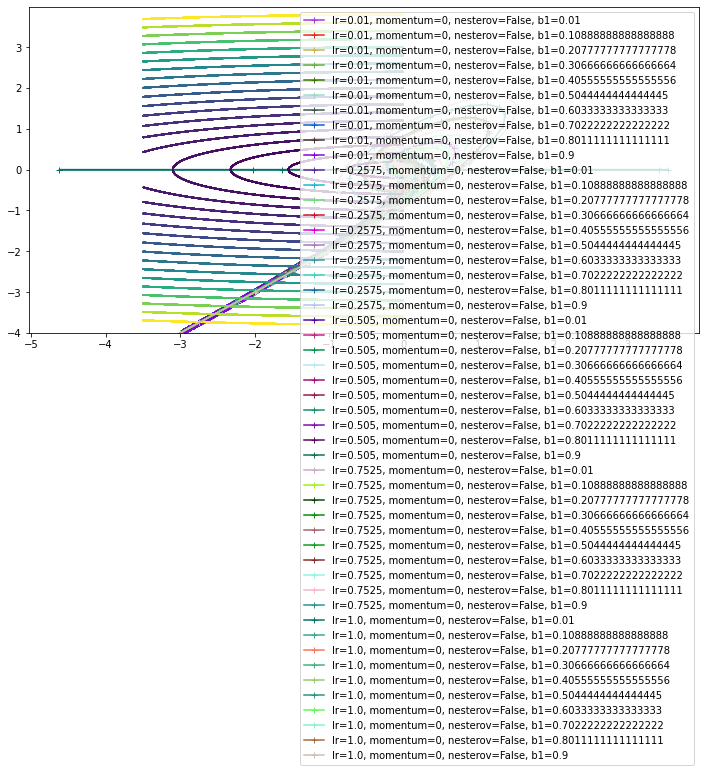

In [12]:
print_learning(optimizer_name="Adam", lrs=np.linspace(0.01, 1, 5), b1s=np.linspace(0.01, 0.9, 10))

#### 6. Identify your best parameters for each of the models above - for the given example. How many steps are needed with these settings to reach the minimum of the function at (0,0) within an accuracy of 1.0e-3

See printout for the above configurations